## This Notebook is created to experiment with input pipelines of tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import glob
import cv2
%config Completer.use_jedi = False

In [3]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Reshape,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
INPUT_PATH = '/kaggle/input'
TRAINING_PATH = '../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/'
IMAGE_SIZE = 128
IMAGE_SIZE_CUSTOM = 100
SHUFFLE = 2589
BATCH = 50
AUTO = tf.data.AUTOTUNE

In [6]:
np.random.seed(45)
tf.random.set_seed(45)

In [7]:
len(os.listdir(TRAINING_PATH))

51033

In [8]:
IMAGE_NAMES = os.listdir(TRAINING_PATH)[:1000]

<h2> For easy to use and fast to train, I am taking only 1000 rows for training and validation </h2>

In [9]:
np.random.set_state = 45
np.random.seed(45)
df = pd.DataFrame(IMAGE_NAMES, columns = ['image'])
df['labels'] = np.random.randint(0, 5, size = 1000, )
df['labels_str'] = df.labels.astype('string')  # for ImageGenerator pipeline and for flow_from_dataframe
df['image_path'] = TRAINING_PATH + df['image']

In [10]:
df.head(5)

,image,labels,labels_str,image_path
0,80b5373b87942b.jpg,3,3,../input/jpeg-happywhale-128x128/train_images-...
1,e113b51585c677.jpg,3,3,../input/jpeg-happywhale-128x128/train_images-...
2,94eb976e25416c.jpg,4,4,../input/jpeg-happywhale-128x128/train_images-...
3,19a45862ab99cd.jpg,0,0,../input/jpeg-happywhale-128x128/train_images-...
4,be9645065510e9.jpg,3,3,../input/jpeg-happywhale-128x128/train_images-...


# Data Analysis

2022-02-20 15:49:50.732789: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


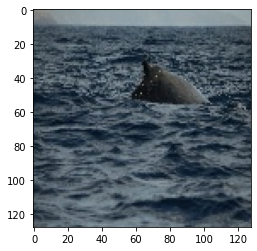

In [11]:
image = tf.io.read_file(df.image_path[0])
image = tf.image.decode_jpeg(image)
plt.imshow(image)

In [12]:
AT =tf.image.resize(image, size = [IMAGE_SIZE_CUSTOM, IMAGE_SIZE_CUSTOM])
AT = tf.cast(AT, tf.float32)/255.0

(100, 100, 3)


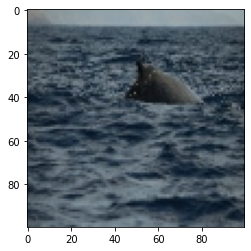

In [14]:
print(AT.shape)
plt.imshow(AT)

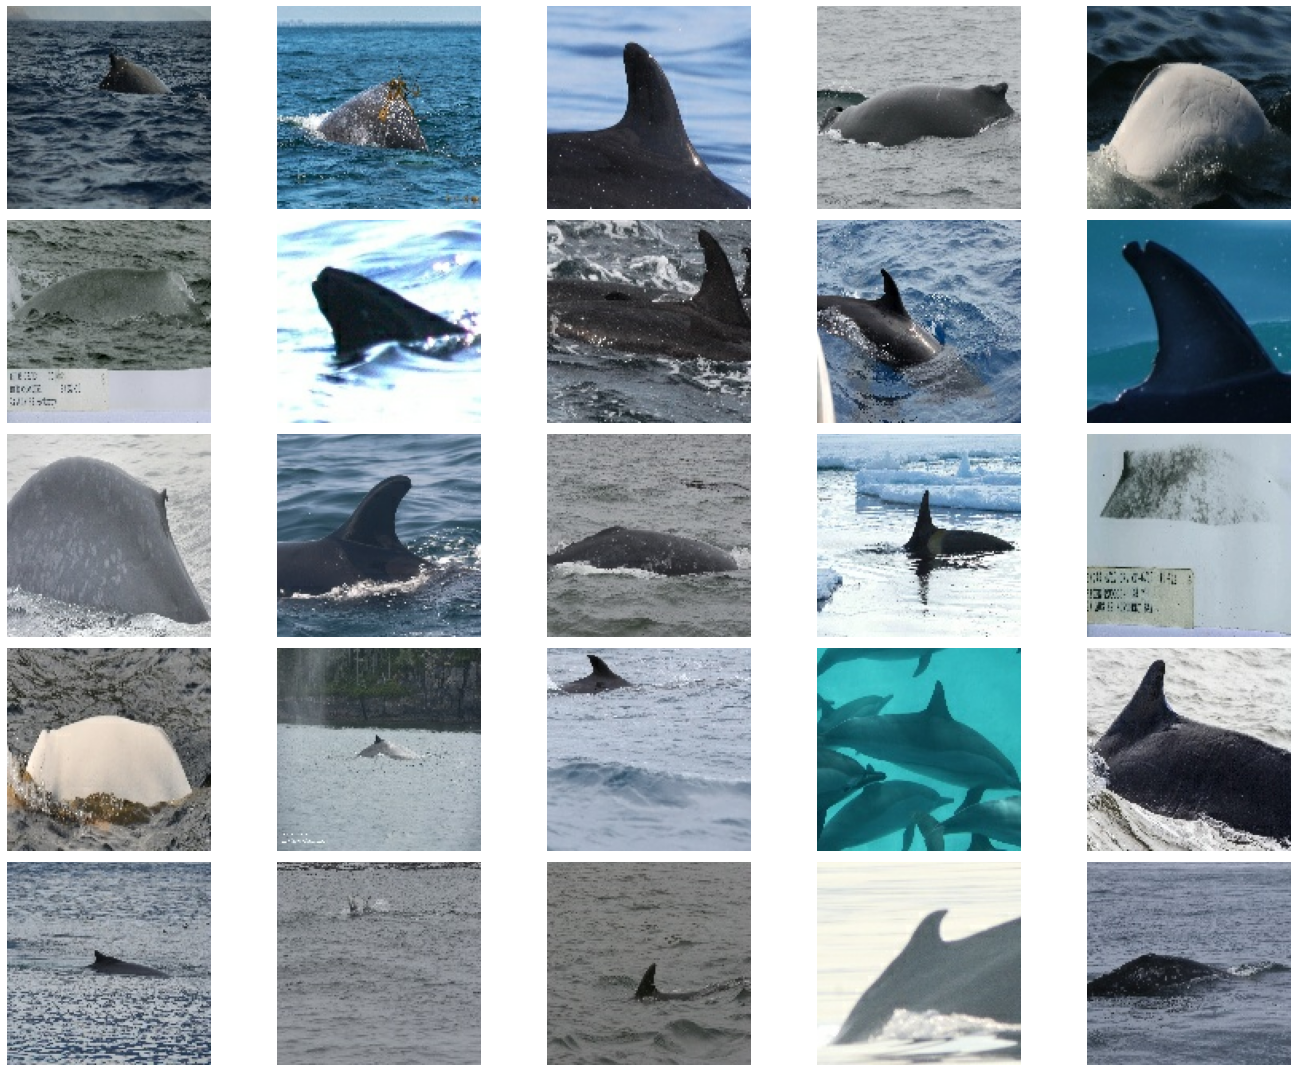

In [15]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (20,15))
for i, path in enumerate(df.image_path[:25]):
    image_1 = tf.io.read_file(path)
    image_1 = tf.image.decode_jpeg(image_1)
    ax.ravel()[i].imshow(image_1)
    ax.ravel()[i].set_axis_off()
    plt.tight_layout()
plt.show()
    

In [16]:
px.bar(data_frame = df.labels.value_counts(), y = 'labels', color = 'labels', )

# Input pipeline 

There are many ways to create input pipeline like:
1. using TFRecord
2. Using Image directory 

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                  horizontal_flip = True,
                                  validation_split = 0.2)
validation_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split = 0.2)

In [ ]:
df.head(1)

In [ ]:
training_set = train_datagen.flow_from_dataframe(df,
                                        TRAINING_PATH,
                                        x_col = 'image', 
                                                y_col = 'labels_str',
                                                seed = 45,
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size = BATCH,
                                                class_mode = 'categorical',
                                                subset = 'training')
validation_set = validation_datagen.flow_from_dataframe(df,
                                                       TRAINING_PATH,
                                                       x_col= 'image',
                                                       y_col = 'labels_str',
                                                       target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                       batch_size = BATCH,
                                                       class_mode= 'categorical',
                                                        subset = 'validation')

## Input pipeline using tf.data

In [50]:
x_train, x_val,y_train, y_val = train_test_split(df.image_path,
                                                  df.labels, test_size = 0.2)
x_train, x_resize, y_train, y_resize = train_test_split(x_train, y_train, test_size = 0.5)

In [54]:
x_train.shape, x_val.shape, x_resize.shape

((400,), (200,), (400,))

In [61]:
x_train[790], y_train[790]

('../input/jpeg-happywhale-128x128/train_images-128-128/train_images-128-128/966443990d9875.jpg',
 4)

In [20]:
list_of_image_path = df.image_path.values
labels = df.labels.values
ds_train = tf.data.Dataset.from_tensor_slices((list_of_image_path, labels))

In [21]:
if np.random.randint(0,2, 1) == 1:
    print('value is 1')
else:
    print('values is 0')

value is 1


In [70]:
def data_loader(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    return dataset

def random_sizing():
    
    return np.random.randint(0,2,1)

def image_parse(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, size= [IMAGE_SIZE_CUSTOM, IMAGE_SIZE_CUSTOM])
    image = tf.cast(image, tf.float32)/255.0
    return image, label

def image_parse_resize(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, size= [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32)/255.0
    return image, label

def data_augmentation(image, label):
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_dataset_validation(filenames, labels):
    dataset = data_loader(filenames, labels)
    dataset = dataset.map(image_parse)
    dataset = dataset.map(data_augmentation)
    dataset = dataset.shuffle(SHUFFLE)
    dataset = dataset.batch(BATCH)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_dataset_train(filenames, labels):
    dataset = data_loader(filenames, labels)
    dataset = dataset.map(image_parse)
    dataset = dataset.map(data_augmentation)
    dataset = dataset.shuffle(SHUFFLE)
    dataset = dataset.batch(BATCH)
    return dataset

def get_resized_dataset(filename, labels):
    dataset = data_loader(filename, labels)
    dataset = dataset.map(image_parse_resize)
    dataset = dataset.map(data_augmentation)
    dataset = dataset.shuffle(SHUFFLE)
    dataset = dataset.batch(BATCH)
    return dataset

def train_dataset(filename_train, labels_train, filename_resize, labels_resize):
    ds_train = get_dataset_train(filename_train, labels_train) 
    ds_resize = get_resized_dataset(filename_resize, labels_resize)
    dataset = ds_train.concatenate(ds_resize)
    dataset = dataset.shuffle(SHUFFLE)
    return dataset

In [71]:
train_ds = train_dataset(x_train, y_train, x_resize, y_resize)

val_ds = get_dataset_validation(x_val, y_val)

In [72]:
tf.constant([4,5]).numpy()

array([4, 5], dtype=int32)

In [73]:
for image, _ in train_ds:
    print(image.shape)

(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 100, 100, 3)
(50, 100, 100, 3)
(50, 128, 128, 3)
(50, 128, 128, 3)


<Figure size 1440x720 with 0 Axes>

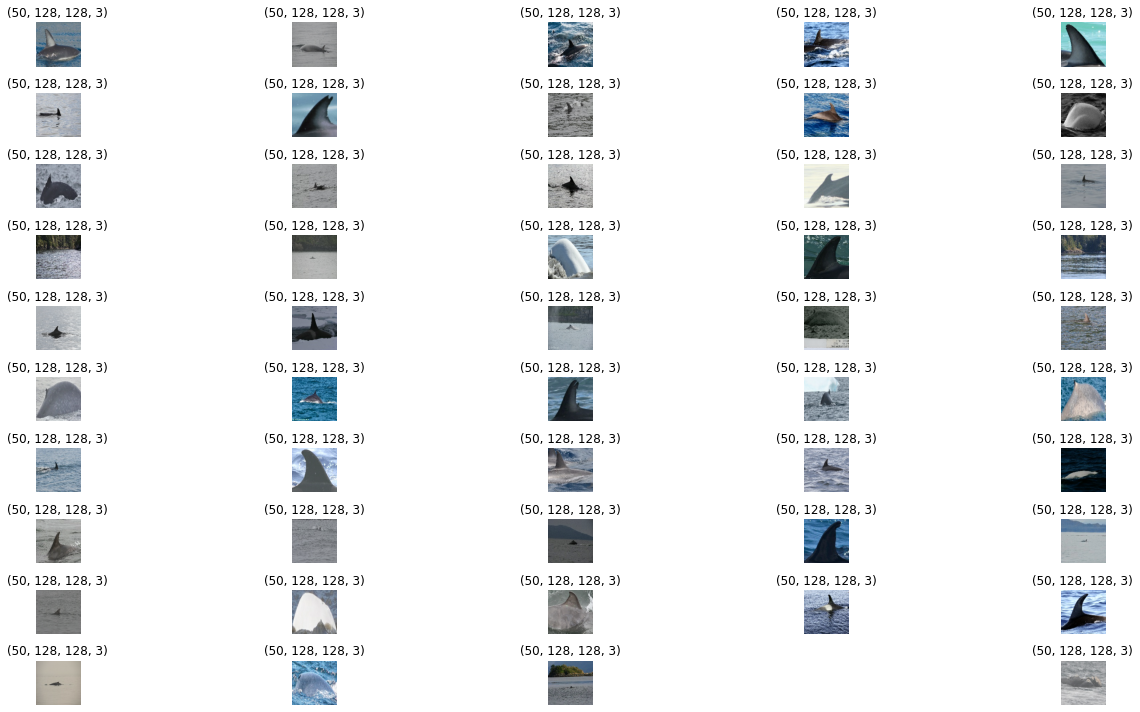

(50, 128, 128, 3)


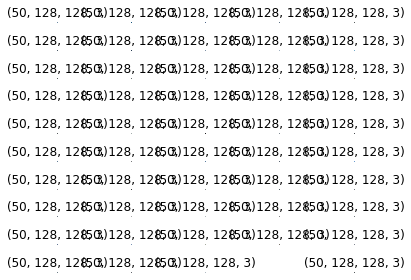

(50, 128, 128, 3)


In [74]:
row, col = 11, 5

row = min(row, BATCH//col)
plt.figure(figsize = (20,10))
plt.subplots(row, col, figsize = (20,10))
for image, label in train_ds.take(2):
    for j in range(row*col):
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(image[j])
        plt.title(label[j].numpy())
        plt.title(image.shape)
        plt.tight_layout()
    plt.show()
    print(image.shape)
    


## Model Building for ImageGenerator

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)) ,
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation = 'softmax')
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(), 
    metrics = ['accuracy'])

In [ ]:
model.fit(training_set , epochs = 2, 
    validation_data = validation_set)

## Model for customer tf.data

In [ ]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Input((IMAGE_SIZE_CUSTOM, IMAGE_SIZE_CUSTOM, 3)) ,
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation = 'softmax')
])

In [ ]:
model_1.summary()

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics = ['accuracy'])

In [ ]:
model_1.fit(train_ds , epochs = 2, 
    validation_data = val_ds)

In [ ]:
image = tf.io.read_file(df.image_path[5])
image = tf.image.decode_jpeg(image)
image = tf.image.resize(image, [IMAGE_SIZE_CUSTOM, IMAGE_SIZE_CUSTOM])
image = tf.cast(image, tf.float32)/255.0

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.reshape(image, [-1, IMAGE_SIZE_CUSTOM, IMAGE_SIZE_CUSTOM, 3])

In [ ]:
model_1.predict(image)

In [ ]:
df.head()

## Model with two different sized images

In [75]:
input = keras.Input(shape = )
if input.shape == (50,128,128,3):
    print('yes')
else:
    print('No')

model = keras.Model(input)

ValueError: Please provide to Input a `shape` or a `tensor` or a `type_spec` argument. Note that `shape` does not include the batch dimension.